In [2]:
import numpy as np
from sklearn.metrics import precision_score, confusion_matrix, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from math import floor
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
list_stop_words = stopwords.words('english')
list_stop_words.append("im")
stopwords1 = set(STOPWORDS)
stopwords1.update(["br", "href","https","t","co","c","b'RT","b'","'","neg","b","neg'", "I m", "I d", "i tt", "ift"])

In [25]:
import pandas as pd
df = pd.read_csv(r'twitter_training.csv')
df.columns = ['id', 'topic', 'polarity', 'tweet']
df = df.dropna()

In [26]:
df.head()


,id,topic,polarity,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [27]:
df.shape                 

(73995, 4)

<body>selecting the data based on the topic as the data is too large</body>

In [28]:
df = df.loc[df['topic'].isin(['Amazon', 'Facebook', 'Xbox(Xseries)','Nvidia','Google','Microsoft', 'FIFA', 'HomeDepot'])]#.groupby('topic').count()
df.shape

(18443, 4)

In [29]:
#function to clean the data
def process_tweet(tweet):
    char = ''
    arr = []
    empty_words = ['',' ', '  ']
    
    for word in str(tweet).replace(",", " ").split():
        #print(word)
        if(word.lower().strip() in ['amazon','facebook','nvidia','google','microsoft']):
            continue
        if len(word) == 1:
            continue
        word = re.sub(r'^RT[\s]','', word)
        word = re.sub(r'https?:\/\/.*[\r\n]*','', word)
        word = re.sub(r'\s+','', word)
        if(re.search('^@[\s]?[a-zA-Z0-9]',word)):
            continue
        if(re.search('^@[\s]+[a-zA-Z0-9]',word)):
            #print(word)
            continue 
        if(re.search('\W',word)):
            word = re.sub(r'\W','',word)
        if(re.search('pi.*om',word)):
            continue
        if(re.search(r'\d',word)):
            continue
        if (re.search(r'\ ',word)):
            continue
        if word.strip().lower() not in list_stop_words and word not in string.punctuation and word not in empty_words and word not in stopwords1:
            arr.append(word.strip())
    return " ".join(arr)

In [30]:
#label encoding
new_col = []
for t in df['tweet']:
    new_col.append(process_tweet(t))
    
df['unique_words'] = new_col
df = df[df['polarity'].isin(['Positive','Negative'])]

temp = [] 
for i in df['polarity']:
    if i == 'Positive':
        temp.append(1)
    else:
        temp.append(0)

df['Sentiment'] = temp

In [31]:
df.head()

,id,topic,polarity,tweet,unique_words,Sentiment
4661,1,Amazon,Negative,@amazon wtf .,wtf,0
4662,1,Amazon,Negative,@ amazon wtf.,wtf,0
4663,1,Amazon,Negative,@ amazon wtf.,wtf,0
4664,1,Amazon,Negative,@amazon wtf?,wtf,0
4665,1,Amazon,Negative,7 @amazon wtf.,wtf,0


In [32]:
#fetching the rare words from the tweets and getting the words that are occured only once 
rare_words = pd.Series(" ".join(df["unique_words"]).split()).value_counts()
rare_words = rare_words[rare_words <= 2]

In [33]:
#removing the words that occured only once
df["unique_words"] = df["unique_words"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))

#getting the features and labels
X = df['unique_words']
y = df['Sentiment']

In [34]:
X.shape

(9894,)

In [11]:
#splitting and converting the data into numerical fearures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)
vectorizer = TfidfVectorizer(min_df = 7)
X_vector_train = vectorizer.fit_transform(X_train)
X_vector_valid = vectorizer.transform(X_valid)
X_vector_train.shape

(7915, 2020)

In [12]:
#converting the data into array and adding bias
x_train_df = X_vector_train.toarray()
x_valid_df = X_vector_valid.toarray()

x_train_df_new = np.insert(x_train_df, 0, 1, axis = 1)
x_valid_df_new = np.insert(x_valid_df, 0, 1, axis = 1)

x_train_df = x_train_df_new
x_valid_df = x_valid_df_new
x_train_df.shape

(7915, 2021)

In [13]:
#converting the labels into arrays
y_train_df = pd.Series(y_train).array
y_valid_df = pd.Series(y_valid).array

<h3> Perceptron </h3>

<body> function to train the perceptron </body>

In [14]:
def perceptron(x, y, w, eta = 0.1, n = 1):
    
    k = 0
    for it in range(n):
        for ind, ex in enumerate(x):
            prod = np.dot(ex, w)

            if prod > 0:
                pred = 1
            else:
                pred = 0

            true_label = y[ind]
            if true_label != pred:
                k+=1
                for i in range(len(w)):

                    w[i] += eta * (true_label - pred )*ex[i]
                
    return w    

<body> training the perceptron on train data and checking the accuracy on validation data</body>

In [15]:
n = [1, 3, 5, 7, 10, 20,30, 50]
eta = [0.01, 0.05, 0.1, 0.5, 0.9]
precision_score_mat = {}
confusion_matrix_mat = {}
for i_n in n:
    for j in eta:
        W = np.zeros((x_train_df.shape[1], 1))
        W = perceptron(x_train_df, y_train_df, W, j, i_n)
        
        pred_valid_y = []
        for i in range(len(x_valid_df)):
            val = np.dot(x_valid_df[i], W)

            if val > 0:
                pred_valid_y.append(1)
            else:
                pred_valid_y.append(0)
        p_s = accuracy_score(y_valid_df,pred_valid_y)
        C_m = confusion_matrix(y_valid_df,pred_valid_y)
        print(f"the accuracy score whene eta = {j} and n = {i_n} is {p_s}")
        precision_score_mat[str(i_n), str(j)] = p_s
        print(f"the confusion matrix whene eta = {j} and n = {i_n} is {C_m}")
        confusion_matrix_mat[str(i_n), str(j)] = C_m

the accuracy score whene eta = 0.01 and n = 1 is 0.8514401212733704
the confusion matrix whene eta = 0.01 and n = 1 is [[971 112]
 [182 714]]
the accuracy score whene eta = 0.05 and n = 1 is 0.8514401212733704
the confusion matrix whene eta = 0.05 and n = 1 is [[971 112]
 [182 714]]
the accuracy score whene eta = 0.1 and n = 1 is 0.8514401212733704
the confusion matrix whene eta = 0.1 and n = 1 is [[971 112]
 [182 714]]
the accuracy score whene eta = 0.5 and n = 1 is 0.8514401212733704
the confusion matrix whene eta = 0.5 and n = 1 is [[971 112]
 [182 714]]
the accuracy score whene eta = 0.9 and n = 1 is 0.8514401212733704
the confusion matrix whene eta = 0.9 and n = 1 is [[971 112]
 [182 714]]
the accuracy score whene eta = 0.01 and n = 3 is 0.8807478524507327
the confusion matrix whene eta = 0.01 and n = 3 is [[1015   68]
 [ 168  728]]
the accuracy score whene eta = 0.05 and n = 3 is 0.8807478524507327
the confusion matrix whene eta = 0.05 and n = 3 is [[1015   68]
 [ 168  728]]
the 

In [16]:
x_train_df.shape

(7915, 2021)

In [17]:
iter_num = []
prec = []
for i in precision_score_mat.keys():
    if i[1] == '0.1':
        iter_num.append(i[0])
        prec.append(precision_score_mat[i])
        print(i, precision_score_mat[i])

('1', '0.1') 0.8514401212733704
('3', '0.1') 0.8807478524507327
('5', '0.1') 0.8807478524507327
('7', '0.1') 0.8817584638706417
('10', '0.1') 0.8913592723597776
('20', '0.1') 0.8888327438100051
('30', '0.1') 0.8888327438100051
('50', '0.1') 0.8832743810005053


Text(0.5, 1.0, 'Accuracy score for different number of iteration for learning rate = 0.1 for perceptron')

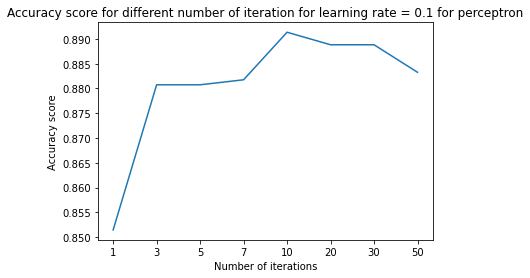

In [18]:
plt.plot(iter_num, prec)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy score")
plt.title("Accuracy score for different number of iteration for learning rate = 0.1 for perceptron")

<h3> Logistic Regression </h3>

In [19]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def calc_h(X, theta):
    z = np.dot(X, theta)
    h = sigmoid(z)
    return h

<body> function to create a logistic regression model </body>

In [20]:
def logistic_regression(X_inp, y, num_iter = 100, alpha = 0.1, lambda_value = 0.0000001):
    cost_epochs = []
    theta = np.zeros(X_inp.shape[1])
    m = y.size
    batchsize = 100
    batches = floor(y.size/batchsize)
    #lambda_value = 0.0000001
    for epoch in range(num_iter):
        cost_list = []
        for i in range(batches):
            s = i*batchsize
            k= s+ batchsize
            Y = y[s:k]
            x = X_inp[s:k,:]
            h = calc_h(x, theta)
            lasso_reg_term = (lambda_value / 2 * batchsize) * sum(abs(theta))
            cost = (-Y * np.log(h) - (1 - Y) * np.log(1 - h)).mean() + lasso_reg_term
            cost_list.append(cost)

            gradient = (np.dot(x.T, (h - Y)))/ batchsize  +  (lambda_value * abs(theta))
            theta -= alpha * gradient

        cost_epochs.append(np.average(cost_list))
        if((epoch + 1 )%10 ==0):    
            print(f"After {epoch+1} epochs, Loss = {cost}")
            

    #print('Adjusted coefficient: {}'.format(theta))
    print(h.shape)
    return theta, cost_epochs

<body> training the logistic regression on various number of iterations </body>

In [ ]:
valid_accuracy = []
ite = [20, 200, 2000, 4000, 10000]
lambda_val = [0.0000001, 0.00001, 0.001, 1, 3, 5, 5000]
for i in ite:
    theta, cost_epochs = logistic_regression(x_train_df, y_train_df, i, alpha = 0.1)
    preds_prob = calc_h(x_valid_df, theta)
    y_pred = preds_prob.round()
    valid_accuracy.append(accuracy_score(y_valid_df,y_pred))

Text(0.5, 1.0, 'Accuracy score for logistic regression for learning rate = 0.1')

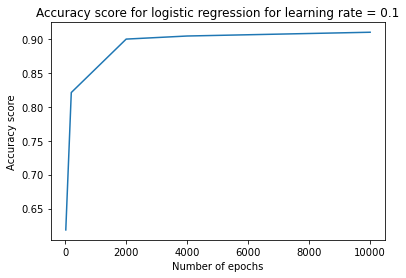

In [22]:
plt.plot(ite, valid_accuracy)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy score")
plt.title("Accuracy score for logistic regression for learning rate = 0.1")

<h3> Neural Networks </h3>

<body> class that creates and trains a neural network model </body>

In [20]:
import random
import numpy as np
 
# helpers
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
 
def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))
 
class Neural_Network:
    # sizes is a list of the number of nodes in each layer
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.accuracy_mat = []
        
        #creating weights and bias
        self.bias = []
        self.weights = []
        for layer in range(len(sizes)):
            if layer != 0:
                self.bias.append(np.random.randn(sizes[layer], 1))
                
                inp_layer = sizes[layer-1]
                self.weights.append(np.random.randn(sizes[layer], inp_layer))
    
    def forwardPropagation(self, a):
        for b, w in zip(self.bias, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
   
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        training_data = list(training_data)
        samples = len(training_data)
       
        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)
       
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size]
                            for k in range(0, samples, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                #print(f"Epoch {j}: {self.evaluate(test_data)} / {n_test}")
                accuracy = self.evaluate(test_data)
                self.accuracy_mat.append(accuracy)
                print(f"Epoch {j}: {accuracy}")
            else:
                print(f"Epoch {j} complete")
   
    def cost_derivative(self, output_activations, y):
        return(output_activations - y)
   
    def backpropagation(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.bias]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # forwardPropagation
        activation = x
        activations = [x] # stores activations layer by layer
        zs = [] # stores z vectors layer by layer
        for b, w in zip(self.bias, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
       
       
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_derivative(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
       
        for _layer in range(2, self.num_layers):
            z = zs[-_layer]
            sp = sigmoid_derivative(z)
            delta = np.dot(self.weights[-_layer+1].transpose(), delta) * sp
            nabla_b[-_layer] = delta
            nabla_w[-_layer] = np.dot(delta, activations[-_layer-1].transpose())
        return (nabla_b, nabla_w)
   
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.bias]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backpropagation(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.bias = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.bias, nabla_b)]
       
    def evaluate(self, test_data):
        pred = []
        true_label = []
        for (x, y) in test_data:
            #print(x, y)
            if y[0] == 1:
                true_label.append(0)
            else:
                true_label.append(1)
                
            pred.append(np.argmax(self.forwardPropagation(x)))
        return accuracy_score(true_label, pred)
    
    def predict(self, data):
        prediction = [np.argmax(self.forwardPropagation(x)) for (x, y) in data]
        return prediction

<body> function for doing one hot encoding. This is typically used on labels as the perceptron has two output neurons.</body>

In [21]:
def one_hot_encode(y):
    encoded = np.zeros((2, 1))
    encoded[y] = 1.0
    return encoded

<body> doing the one hot encoding on the labels. </body>

In [22]:
x_train_df = X_vector_train.toarray()
x_valid_df = X_vector_valid.toarray()
y_train_df = np.array(y_train)
y_valid_df = np.array(y_valid)

x_train_df = [np.reshape(x, (X_vector_train.shape[1], 1)) for x in x_train_df]
y_train_df = [one_hot_encode(y) for y in y_train_df]

x_valid_df = [np.reshape(x, (X_vector_train.shape[1], 1)) for x in x_valid_df]
y_valid_df = [one_hot_encode(y) for y in y_valid_df]

training_data = zip(x_train_df,y_train_df)
valid_data = zip(x_valid_df,y_valid_df)

<body> creating and training the networkk. </body>

In [ ]:
net = Neural_Network([X_vector_train.shape[1], 100, 25, 2])
net.SGD(training_data, 500, 200, 0.5, test_data=valid_data)

In [ ]:
accuracy = net.accuracy_mat
accuracy

Text(0.5, 1.0, 'Accuracy vs number of epochs on validation data for Neural Networks with 2 layers')

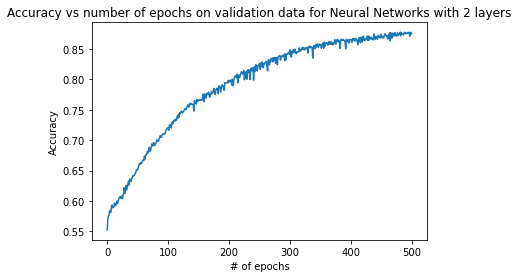

In [25]:
plt.plot(accuracy)
plt.xlabel('# of epochs')
plt.ylabel("Accuracy")
plt.title('Accuracy vs number of epochs on validation data for Neural Networks with 2 layers')

<h3> prediction on test data </h3>

In [29]:
df_test = pd.read_csv(r'twitter_validation.csv')
df_test.columns = ['id', 'topic', 'polarity', 'tweet']
df_test = df_test.loc[df_test['polarity'].isin(['Positive','Negative'])]
df_test = df_test.dropna()
df_test = df_test.loc[df_test['topic'].isin(['Amazon', 'Facebook', 'Xbox(Xseries)','Nvidia','Google','Microsoft', 'FIFA', 'HomeDepot'])]#.groupby('topic').count()
df_test.shape

(120, 4)

<body> label encoding for test data labels.</body>

In [30]:
new_col = []
for t in df_test['tweet']:
    new_col.append(process_tweet(t))
    
df_test['unique_words'] = new_col

temp = [] 
for i in df_test['polarity']:
    if i == 'Positive':
        temp.append(1)
    else:
        temp.append(0)

        
df_test['Sentiment'] = temp
df_test

,id,topic,polarity,tweet,unique_words,Sentiment
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,pay WORD functions poorly Chromebook,0
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Hi Ive Madeleine McCann cellar past years litt...,0
14,9135,Nvidia,Positive,Congrats to the NVIDIA NeMo team for the 1.0.0...,Congrats NeMo team release candidate Really ex...,1
18,8056,Microsoft,Negative,What does that say about Microsoft hardware & ...,say hardware software security Man gets hacked,0
29,8857,Nvidia,Positive,Watching NVIDIA position itself as not just a ...,Watching position leading hardware manufacture...,1
...,...,...,...,...,...,...
970,8318,Microsoft,Negative,Why didn’t anyone think of this acronym for BL...,didnt anyone think acronym BLM Batteries Lives...,0
973,397,Amazon,Positive,#Amazon Best Seller!\n\nScreen Cleaner Kit - B...,Amazon Best Seller Screen Cleaner Kit Best LED...,1
988,5708,HomeDepot,Positive,Thank you to Matching funds Home Depot RW paym...,Thank Matching funds Home Depot RW payment gen...,1
992,314,Amazon,Negative,Please explain how this is possible! How can t...,Please explain possible let companies overchar...,0


<body> removing the words that occured less than once in test data.</body>

In [31]:
df_test["unique_words"] = df_test["unique_words"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
X_test_df = df_test['unique_words']
y_test_df = df_test['Sentiment']

<body>converting the entire train data and validation data into numerical features and transforming the test data into numerical features.</body>

In [32]:
vectorizer_test = TfidfVectorizer(min_df = 7)
Final_Data = vectorizer_test.fit_transform(X)
X_vector_test= vectorizer_test.transform(X_test_df)
x_train = Final_Data.toarray()
x_test = X_vector_test.toarray()

x_train_df_new = np.insert(x_train, 0, 1, axis = 1)
x_test_df_new = np.insert(x_test, 0, 1, axis = 1)

x_train = x_train_df_new
x_test  = x_test_df_new

y_train = pd.Series(y).array
y_test = pd.Series(y_test_df).array

<body> training the perceptron on entire train and validation data, then checking its accuracy on test data.</body>

In [35]:
final_perceptron  = np.zeros((x_train.shape[1], 1))
final_perceptron = perceptron(x_train, y_train, final_perceptron, 0.1,30)

pred_test_y = []
for i in range(len(x_test)):
    val = np.dot(x_test[i], final_perceptron)

    if val > 0:
        pred_test_y.append(1)
    else:
        pred_test_y.append(0)
        
p_s = accuracy_score(y_test, pred_test_y)
C_m = confusion_matrix(y_test,pred_test_y)
print(f"the accuracy score for eta = 0.1 and n = 30 is {p_s}")
print(f"the confusion matrix for eta = 0.1 and n = 30 is {C_m}")

the accuracy score for eta = 0.1 and n = 30 is 0.9166666666666666
the confusion matrix for eta = 0.1 and n = 30 is [[65  0]
 [10 45]]


<body> training the logistic regression model on entire train and validation data, then checking its accuracy on test data.</body>

In [ ]:
final_theta, cost_epochs = logistic_regression(x_train, y_train, 10000, alpha = 0.1)

In [37]:
preds_prob = calc_h(x_test, final_theta)
y_pred = preds_prob.round()
print("The accuracy of the given model on test data for logistic regression is ",accuracy_score(y_test,y_pred))

The accuracy of the given model on test data for logistic regression is  0.975


In [38]:
C_m_log = confusion_matrix(y_test,y_pred)
print("The confusion matrix of the given model on test data for logistic regression is ",C_m_log)

The confusion matrix of the given model on test data for logistic regression is  [[64  1]
 [ 2 53]]


<h5> predicting via the neural network </h5>

In [39]:
X_vector_test= vectorizer.transform(X_test_df)
x_test_df_new = [np.reshape(x, (X_vector_test.shape[1], 1)) for x in X_vector_test.toarray()]
y_test = y_test_df.array
test_data = zip(x_test_df_new, y_test)

pred = net.predict(test_data)
#pred= pred.round()
print("The accuracy score of neural networks with 2layers on test data is ",accuracy_score(y_test, pred))

The accuracy score of neural networks with 2layers on test data is  0.975


In [40]:
confusion_matrix(y_test,pred)

array([[65,  0],
       [ 3, 52]], dtype=int64)